# Objectives

1. Reduce tree with treemmer.
1. Add treemmer info to dataframe.
1. Plot reduction

---
# Setup

## Module Imports

In [21]:
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from Bio import Phylo
import seaborn as sns

## Input Paths

In [2]:
tree_path = "../../docs/results/latest/parse_tree/parse_tree.nwk"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
tree_df_path = "../../docs/results/latest/parse_tree/parse_tree.tsv"
treemmer_path = "../scripts/Treemmer.py"

auspice_config_path = "../../config/auspice_config.json" 
auspice_colors_path="../../docs/results/latest/parse_tree/parse_tree_colors.tsv"
auspice_latlons_path="../../docs/results/latest/parse_tree/parse_tree_latlon.tsv"
auspice_remote_dir_path = "../../auspice/"

outdir = "../../docs/results/latest/treemmer"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [157]:
from config import *

SCRIPT_NAME = "treemmer"

## Import Tree and Dataframe

In [7]:
tree_pre = Phylo.read(tree_path, "newick")
tree_pre.ladderize(reverse=False)

tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

# 1. Reduce Tree with Treemmer

In [8]:
# Remove old treemmer results
old_treemmer_files = os.popen("ls {}*".format(os.path.join(outdir,"treemmer"))).read().strip().split("\n")
for file in old_treemmer_files:
    if not file: continue
    print("Deleting old treemmer file:", file)
    os.remove(file)
    
# Copy over the tree to the new directory
out_path_tree = os.path.join(outdir, "treemmer.nwk")
os.system("cp {old_tree} {new_tree}".format(old_tree = tree_path, new_tree = out_path_tree))

# Run treemmer
os.system("python3 {treemmer} {tree} --verbose 0 --plot_complete".format(treemmer=treemmer_path, tree=out_path_tree))

Deleting old treemmer file: ../../docs/results/latest/treemmer/treemmer.nwk


0

## Create a dataframe for the output

In [20]:
treemmer_df_path = os.path.join(outdir, "treemmer_res_1_LD.txt")
treemmer_df = pd.read_csv(treemmer_df_path, sep='\t', header=None)
treemmer_df.columns = ["rtl", "taxa"]
treemmer_df

,rtl,taxa
0,1.000000,630
1,1.000000,629
2,1.000000,628
3,1.000000,627
4,1.000000,626
...,...,...
626,0.200203,7
627,0.169656,6
628,0.145812,5
629,0.094632,4


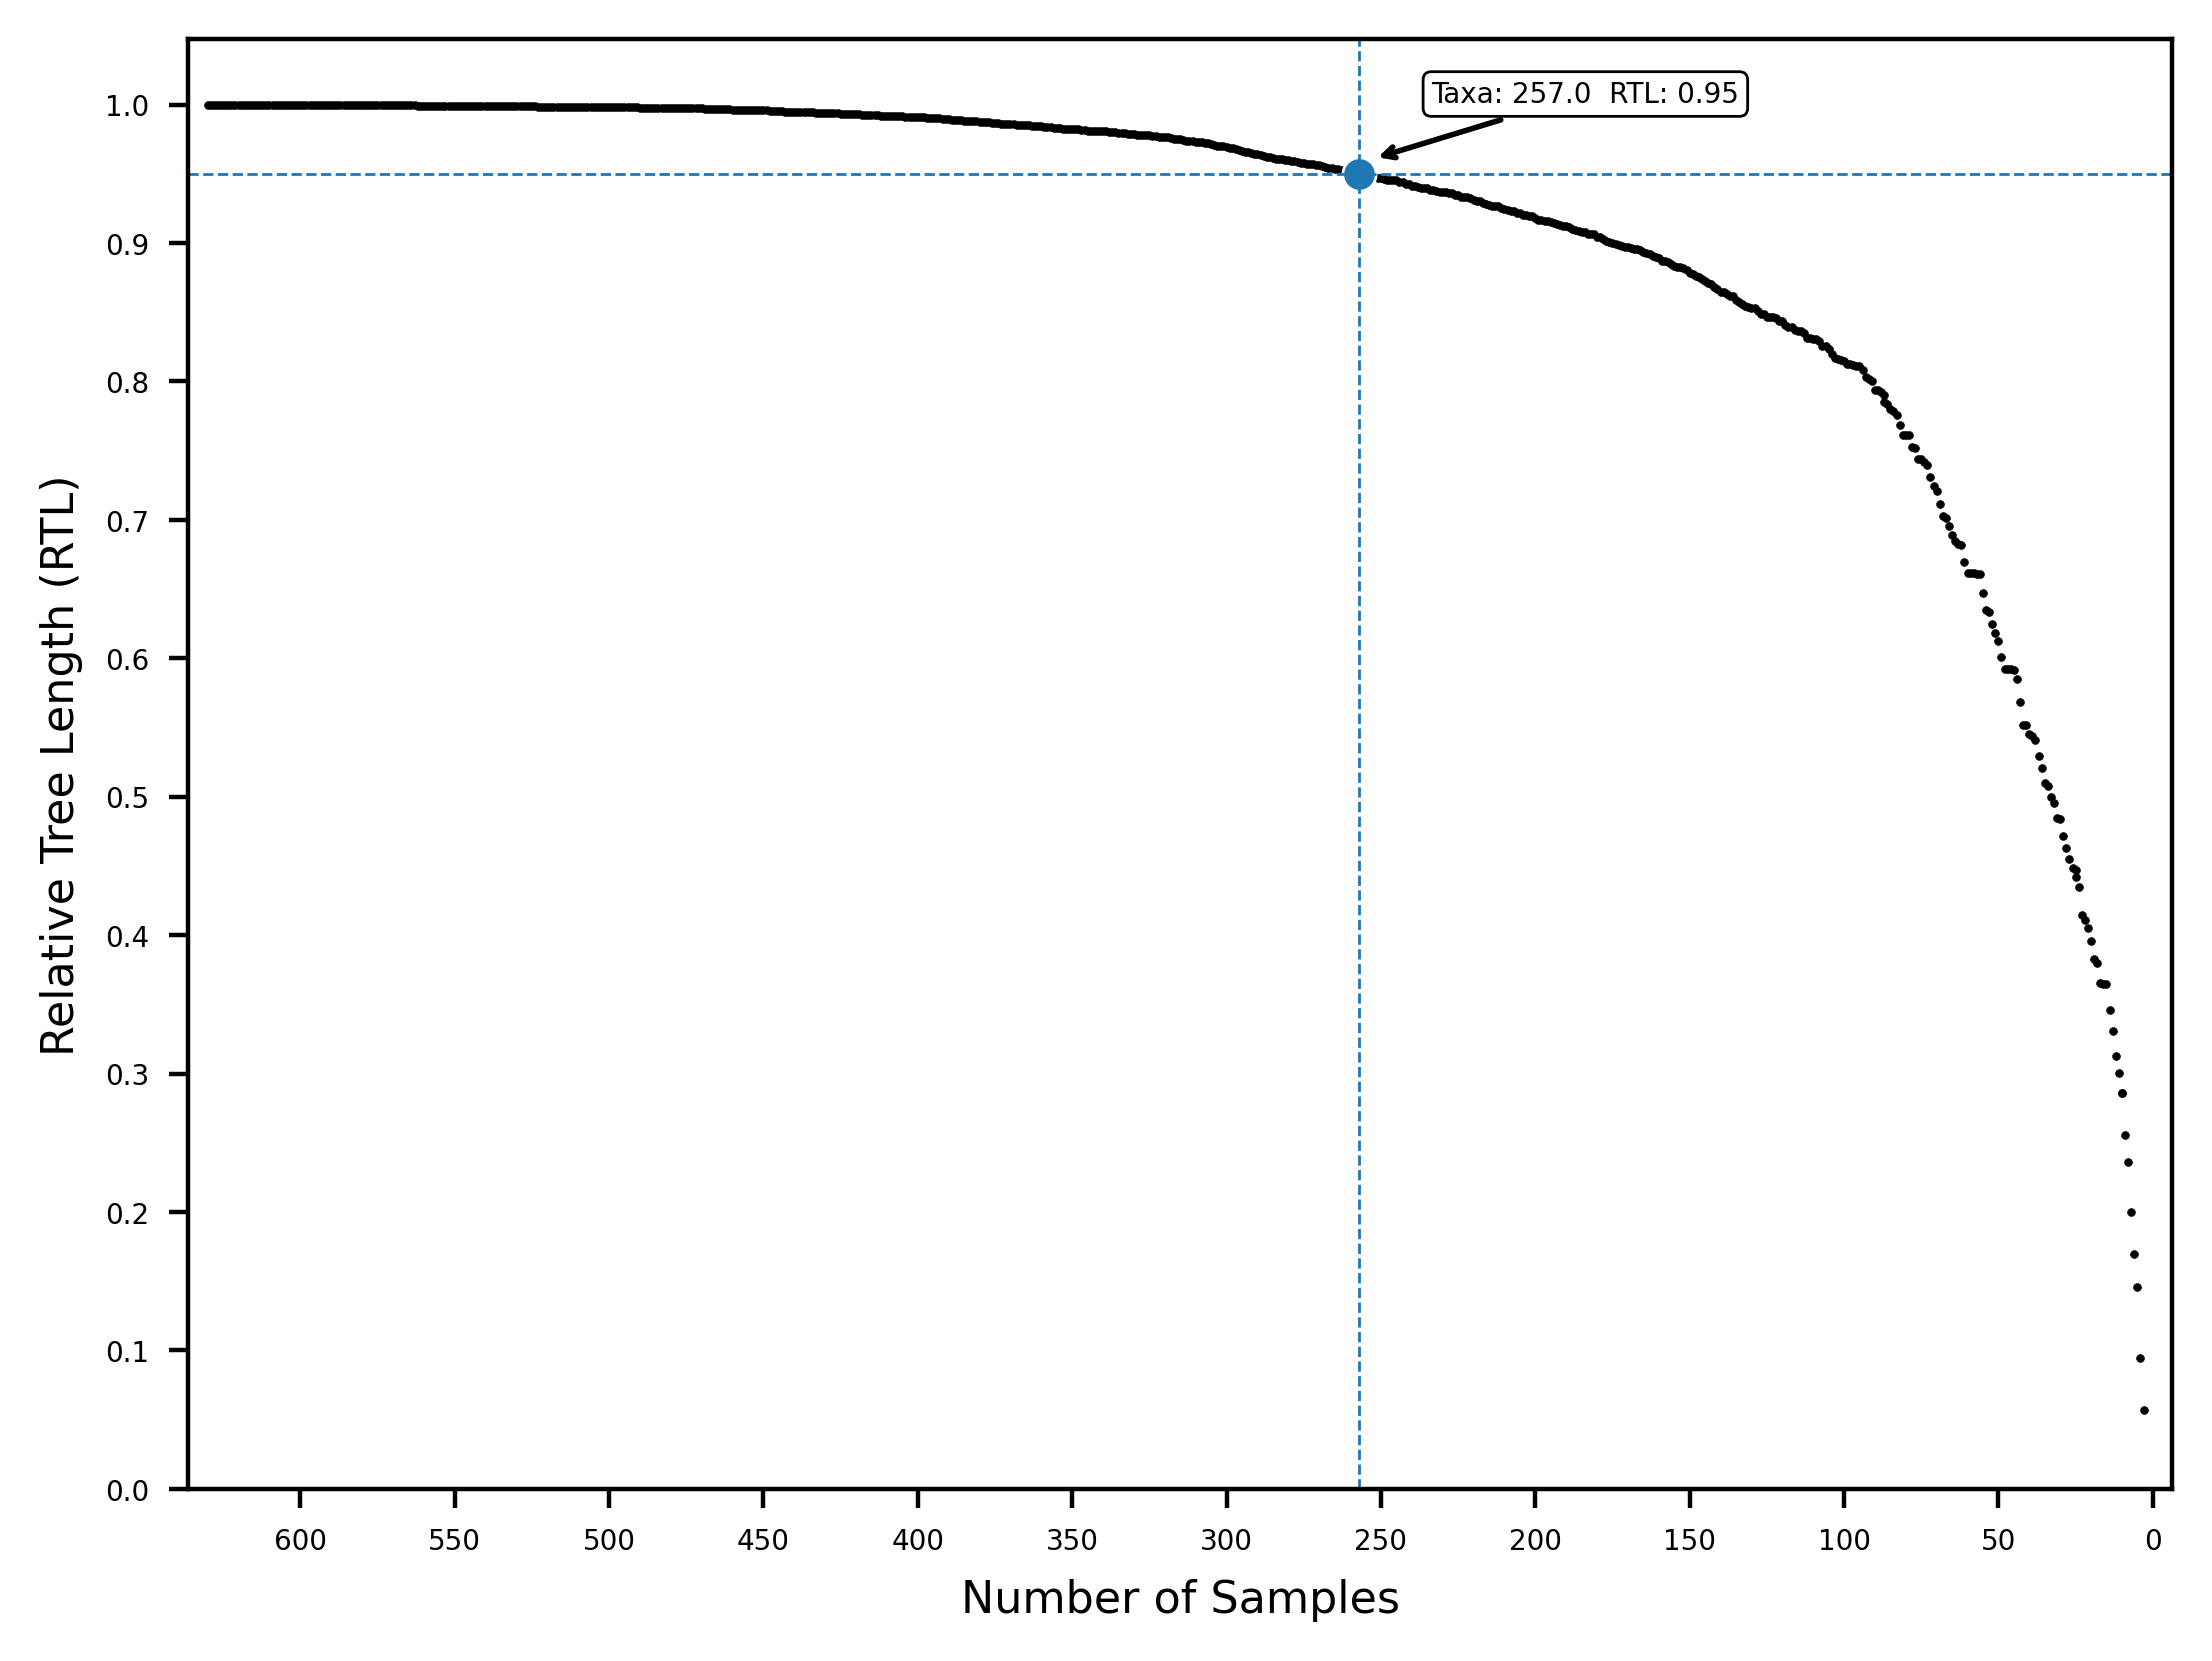

In [156]:
TARGET_RTL = 0.95
target_taxa = max(treemmer_df["taxa"])
target_iloc = 0

# Identify the number of taxa
for rec in treemmer_df.iterrows():
    iloc = rec[0]
    rtl = rec[1]["rtl"]
    taxa = rec[1]["taxa"] 
    # Stop once threshold is passed
    if rtl >= TARGET_RTL:
        target_taxa = taxa   
        target_iloc = iloc
    else:
        break
        
# Setup the figure        
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize)

# Plot Taxa vs. RTL
sns.scatterplot(data=treemmer_df, 
                x="taxa", 
                y="rtl", 
                color="black", 
                s=2, 
                edgecolor="black",
                ax=ax1)

# Plot the candidate point
sns.scatterplot(data=treemmer_df.iloc[[match_iloc]], 
                x="taxa", 
                y="rtl")

ax1.set_xlabel("Number of Samples")
ax1.set_ylabel("Relative Tree Length (RTL)")


ax1.set_xticks([t for t in range(0,max(treemmer_df["taxa"]),50)])
ax1.set_yticks([t/10 for t in range(0,11,1)])

x_buffer = max(treemmer_df["taxa"]) * 0.01
y_buffer = max(treemmer_df["rtl"]) * 0.01
ax1.set_xlim(max(treemmer_df["taxa"]) + x_buffer, 0 - x_buffer)

ax1.axhline(TARGET_RTL, linestyle="--")
ax1.axvline(target_taxa, linestyle="--")

# Annotation
ax1.annotate("Taxa: {}  RTL: {}".format(target_taxa, TARGET_RTL), 
             xy=(target_taxa / 1.01, TARGET_RTL * 1.01), 
             xycoords="data",      
             va="bottom", 
             ha="left",
             xytext=(target_taxa / 1.10, TARGET_RTL * 1.05), 
             textcoords='data',     
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),             
             bbox=dict(boxstyle="round", fc="w", lw=0.5))

# Export
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtl." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

In [ ]:
os.system("python3 {treemmer} {tree} --stop_at_X_leaves {stop} --verbose 0 --plot_complete".format(treemmer=treemmer_path, 
                                                                                                    tree=out_path_tree,
                                                                                                    stop=str())
                                                                                                   )

# 2. Prune Tree, Dataframe, Alignment

In [ ]:
tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

treemmer_path = os.path.join(outdir, "treemmer_trimmed_tree_X_200.nwk")
treemmer_tree = Phylo.read(treemmer_path, "newick")
treemmer_tips = [t.name for t in treemmer_tree.get_terminals()]

for t in tree.get_terminals():
    
    if t.name not in treemmer_tips:
        # Remove tip from tree
        tree.prune(t)
        
        # Remove sample from dataframe
        tree_df.drop(t.name, inplace=True)

Phylo.draw(tree, 
        show_confidence=False, 
        label_func = lambda x: '',
        do_show=False,
        )

---
# 3. Plot

In [ ]:
"""size = "200"
tree_post_path = os.path.join(outdir, "treemmer_trimmed_tree_X_{}.nwk".format(size))
tree_post = Phylo.read(tree_post_path, "newick")
tree_post.ladderize(reverse=False)

#tree_post_tips_path = 

# Setup the figure
fig = plt.figure(dpi=dpi,
                 figsize=(figsize[0] * 1, figsize[1] * 1),
                 )

# Setup the grid
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


# -----------------------------------------------------
# Axis 1: Phylogeny Pre-Filter

for c in tree_pre.get_terminals():
    if c.name not in tree_dict[size]["tips"]:
        c.color = "red"

Phylo.draw(tree_pre, 
        show_confidence=False, 
        label_func = lambda x: '',
        do_show=False,
        axes=ax1)

# Labels
ax1.set_xlabel("Branch Length")
ax1.set_yticks([])
ax1.set_ylabel('')
num_tips = len(tree_pre.get_terminals())
ax1.set_title("Phylogeny Pre Filter (N={})".format(num_tips))


Phylo.draw(tree_post, 
        show_confidence=False, 
        label_func = lambda x: '',
        do_show=False,
        axes=ax2)

# Labels
ax2.set_xlabel("Branch Length")
ax2.set_yticks([])
ax2.set_ylabel('')
num_tips = len(tree_post.get_terminals())
ax2.set_title("Phylogeny Post Filter (N={})".format(num_tips))"""

---
# 2. Add treemmer info to dataframe

---
# Export

## Save Tree and Dataframe

In [ ]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

out_path_xml = os.path.join(outdir,  SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )

Phylo.write(tree, out_path_xml, 'phyloxml')
Phylo.write(tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Augur JSON

In [ ]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tree, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

## Auspice JSON

In [ ]:
auspice_dict = auspice_export(
    tree=tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlons_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")